<a href="https://www.kaggle.com/code/emanafi/lyricgen?scriptVersionId=257958313" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

**LyricGen - An AI-Powered Lyric Completion Tool**

By Eman Sarah Afi

_Fall 2024_

# **1. Data Cleaning & Preprocessing:**

In [1]:
import os
import pandas as pd
import random
import re
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter
from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Input, Embedding, Dense, LayerNormalization, Dropout, MultiHeadAttention, Layer, Add
from tensorflow.keras.models import Model

# Suppress TensorFlow warnings
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

print("Libraries imported successfully!")

Libraries imported successfully!


In [2]:
# Load the dataset
dataset = pd.read_csv('/kaggle/input/genius-song-lyrics-with-language-information/song_lyrics.csv')

# Display the first 10 rows of the dataset
print(dataset.head(10))

# Display dataset info (columns, data-types, non-null counts)
print(dataset.info())

               title  tag     artist  year   views  \
0          Killa Cam  rap    Cam'ron  2004  173166   
1         Can I Live  rap      JAY-Z  1996  468624   
2  Forgive Me Father  rap   Fabolous  2003    4743   
3       Down and Out  rap    Cam'ron  2004  144404   
4             Fly In  rap  Lil Wayne  2005   78271   
5     Lollipop Remix  rap  Lil Wayne  2008  580832   
6         Im Not You  rap     Clipse  2002   28645   
7        Family Ties  rap    Cam'ron  2004   41960   
8  Rockin and Rollin  rap    Cam'ron  1998    6399   
9      Lord You Know  rap    Cam'ron  2004   11882   

                                       features  \
0                   {"Cam\\'ron","Opera Steve"}   
1                                            {}   
2                                            {}   
3  {"Cam\\'ron","Kanye West","Syleena Johnson"}   
4                                            {}   
5                 {"Kanye West","Static Major"}   
6   {Jadakiss,"Styles P","Roscoe P. Coldchain"} 

In [3]:
# Print the percentage of missing values per column
print(dataset.isnull().sum() / len(dataset) * 100)

title            0.003661
tag              0.000000
artist           0.000000
year             0.000000
views            0.000000
features         0.000000
lyrics           0.000000
id               0.000000
language_cld3    1.771539
language_ft      2.615886
language         4.419170
dtype: float64


In [4]:
# Define target languages (English, French, Arabic)
target_languages = ['en', 'fr', 'ar']

# Total rows in the dataset
total_rows = len(dataset)

# Calculate the percentage for each target language
percentages = {
    lang: (len(dataset[dataset['language'] == lang]) / total_rows) * 100
    for lang in target_languages
}

# Display the percentages
for lang, percentage in percentages.items():
    print(f"Percentage of rows with '{lang}': {percentage:.2f}%")

Percentage of rows with 'en': 65.71%
Percentage of rows with 'fr': 3.69%
Percentage of rows with 'ar': 0.19%


Naturally, considering that the intention is to work with three languages (English, French & Arabic), we have to filter the dataset to include the rows with these languages only. 

However, considering that the percentage of 'en' is extremely high, which could lead to performance issues on Kaggle, it is recommended to take a sample of rows that have 'en' as the language.

Other than that, the text is cleaned by removing punctuation, unique characters, and converting it to lowercase (except for Arabic). Plus, structural tags (e.g., [Chorus: ...]) will be removed to reduce the noise, and repeated lyrics were handled to prevent redundancy in tokenized sequences.

Finally, the dataset should only keep the columns it needs for this project, which in this case, the kept columns are 'language' and 'cleaned_lyrics'.

In [5]:
# Filter dataset using the 'language' column and create an explicit copy
filtered_dataset = dataset[dataset['language'].isin(target_languages)].copy()

# Function for cleaning multilingual lyrics (removes punctuation)
def clean_multilingual_lyrics_simple(lyric, lang):
    if pd.isnull(lyric):  # Handle missing lyrics
        return ""
    
    # Remove structural tags (e.g., [Chorus: Opera Steve & Cam'ron])
    lyric = re.sub(r"\[.*?\]", "", lyric)
    
    # Handle language-specific cleaning
    if lang == 'en':
        lyric = re.sub(r"[^a-zA-Z0-9\s]", "", lyric).lower()
    elif lang == 'fr':
        lyric = re.sub(r"[^a-zA-ZÀ-ÿ0-9\s]", "", lyric).lower()
    elif lang == 'ar':
        lyric = re.sub(r"[^\u0600-\u06FF0-9\s]", "", lyric)
    
    # Remove extra whitespace
    lyric = " ".join(lyric.split())
    return lyric

# Inspect group sizes
group_sizes = filtered_dataset['language'].value_counts()
print("Group sizes before sampling:", group_sizes)

# Set target sample size for each language
target_sample_size = 9000

# Sample data for each language
sampled_en = filtered_dataset[filtered_dataset['language'] == 'en'].sample(
    n=min(target_sample_size, len(filtered_dataset[filtered_dataset['language'] == 'en'])),
    random_state=42
)

sampled_fr = filtered_dataset[filtered_dataset['language'] == 'fr'].sample(
    n=min(target_sample_size, len(filtered_dataset[filtered_dataset['language'] == 'fr'])),
    random_state=42
)

sampled_ar = filtered_dataset[filtered_dataset['language'] == 'ar'].sample(
    n=min(target_sample_size, len(filtered_dataset[filtered_dataset['language'] == 'ar'])),
    random_state=42
)

# Combine all sampled data
sampled_dataset = pd.concat([sampled_en, sampled_fr, sampled_ar])

# Apply the cleaning function to the sampled dataset
sampled_dataset = sampled_dataset.assign(
    cleaned_lyrics=sampled_dataset.apply(
        lambda row: clean_multilingual_lyrics_simple(row['lyrics'], row['language']),
        axis=1
    )
)

# Keep only 'language' and 'cleaned_lyrics' columns
sampled_dataset = sampled_dataset[['language', 'cleaned_lyrics']]

# Display dataset summary
print(f"Final dataset columns: {sampled_dataset.columns.tolist()}")
print(f"Number of rows: {len(sampled_dataset)}")
print(sampled_dataset['language'].value_counts())
print(sampled_dataset.head())

Group sizes before sampling: language
en    3374198
fr     189436
ar       9889
Name: count, dtype: int64
Final dataset columns: ['language', 'cleaned_lyrics']
Number of rows: 27000
language
en    9000
fr    9000
ar    9000
Name: count, dtype: int64
        language                                     cleaned_lyrics
2645152       en  dont want to be along anymore dont want to hea...
1939177       en  africa rappers fuck you i dey greet so you guy...
969631        en  every time i kiss somebody new i make believe ...
4041818       en  i am the one who calls your name the day you l...
1976310       en  hella sketchy im always glistenin im always gl...


After the cleaning phase, it is preferred to check if there are any duplicated rows before proceeding with the embedding & tokenization phase. 

In [6]:
# Number of duplicated rows
num_duplicates = sampled_dataset.duplicated().sum()

# Percentage of duplicated rows
percentage_duplicates = (num_duplicates / len(sampled_dataset)) * 100
print(f"Percentage of duplicated rows: {percentage_duplicates:.2f}%")

final_dataset = sampled_dataset.drop_duplicates()

# Number of duplicated rows
num_duplicates = final_dataset.duplicated().sum()

# Check for duplicated rows again
percentage_duplicates = (num_duplicates / len(final_dataset)) * 100
print(f"Percentage of duplicated rows: {percentage_duplicates:.2f}%")

Percentage of duplicated rows: 0.27%
Percentage of duplicated rows: 0.00%


In [7]:
# Print the percentage of missing values per column
print(final_dataset.isnull().sum() / len(final_dataset) * 100)

language          0.0
cleaned_lyrics    0.0
dtype: float64


# **2. Embedding Preparation:**

The purpose of the embedding phase here is to transform text data into numerical representations suitable for Transformer-based models. 

To explain further:
- **max_vocab_size** limits the vocabulary to the most frequent 30,000 words for optimal performance
- **max_sequence_length** sets a fixed sequence length of 80 for uniform input size

These values were chosen while taking into consideration the complexity of the multilingual and diverse nature of the Genius dataset, as well as memory constraints on Kaggle.

**Important Note on Vocabulary Management:**
The tokenizer discovers all unique tokens in the dataset but uses only the top 30,000 most frequent tokens during training and generation. This approach:
- **Reduces memory usage** by limiting the embedding and output layer sizes
- **Improves training stability** by focusing on the most relevant vocabulary
- **Prevents out-of-vocabulary issues** during generation by maintaining a consistent vocabulary size

Then, tokenization is done for all languages where the cleaned lyrics are converted into sequences of integers, and out-of-vocabulary words are replaced by a special token (`<OOV>`). After that, padding ensures that all sequences have the same length for compatibility reasons.

In [8]:
# Define parameters
max_vocab_size = 30000
max_sequence_length = 80
sos_token = "<sos>"
eos_token = "<eos>"

# 1. Create a single, unified tokenizer for all languages
tokenizer = Tokenizer(num_words=max_vocab_size, oov_token="<OOV>")

# 2. Prepare all texts with special tokens, INCLUDING a language token
all_lyrics_with_lang = final_dataset[['cleaned_lyrics', 'language']].astype(str).values.tolist()
texts_with_tokens = [f"<{lang}> {sos_token} {text} {eos_token}" for text, lang in all_lyrics_with_lang]

# 3. Fit the single tokenizer on all available text data
print("Fitting a unified tokenizer on all languages...")
tokenizer.fit_on_texts(texts_with_tokens)
print("Tokenizer fitting complete.")

# 4. Use the configured max vocabulary size (not the full discovered size)
vocab_size = max_vocab_size
print(f"Using configured vocabulary size: {vocab_size}")
print(f"Full discovered vocabulary size: {len(tokenizer.word_index) + 1}")

# Verify that our tokenizer will respect the num_words limit
if len(tokenizer.word_index) + 1 > max_vocab_size:
    print(f"Note: Tokenizer discovered {len(tokenizer.word_index) + 1} unique tokens,")
    print(f"but will use only the top {max_vocab_size} most frequent tokens.")
else:
    print(f"All discovered tokens ({len(tokenizer.word_index) + 1}) fit within the limit.")

# 5. Convert all texts to integer sequences
print("Converting texts to sequences...")
sequences = tokenizer.texts_to_sequences(texts_with_tokens)

# 6. Pad all sequences to the same fixed length
X_padded = pad_sequences(
    sequences, 
    maxlen=max_sequence_length, 
    padding='post', 
    truncating='post',
    dtype='int32'
)
print("Padding complete.")

# 7. Split the single dataset into training, validation, and test sets
X_train, X_temp = train_test_split(X_padded, test_size=0.2, random_state=42)
X_val, X_test = train_test_split(X_temp, test_size=0.5, random_state=42)

# Final Summaries
print(f"\nTotal padded sequences: {len(X_padded)}")
print(f"Training samples: {len(X_train)}")
print(f"Validation samples: {len(X_val)}")
print(f"Test samples: {len(X_test)}")

# Example data
print(f"\nExample processed sequence (from X_train): \n{X_train[0]}")
print("\nData is now correctly prepared for the decoder-only transformer.")

Fitting a unified tokenizer on all languages...
Tokenizer fitting complete.
Using configured vocabulary size: 30000
Full discovered vocabulary size: 510228
Note: Tokenizer discovered 510228 unique tokens,
but will use only the top 30000 most frequent tokens.
Converting texts to sequences...
Padding complete.

Total padded sequences: 26928
Training samples: 21542
Validation samples: 2693
Test samples: 2693

Example processed sequence (from X_train): 
[   30    36    66    50    51    19 25389  8735    66    50    51    19
 23022  8735    59  6311    10   113   850    66    50    51    19 25389
  8735    66    50    51    19 23022  8735    59  6311    10   113   850
     5    90   367    10   947   165     2  3991   944  2444    23     7
  3991    27  1077   388  2348  9781  4833    52  1954     7  1115    52
    51  2833   170     1   571   211   301  1502     1  4994   200     3
   146   414    90   239 18122   706    57   192]

Data is now correctly prepared for the decoder-only trans

# **3. Output Readiness Check:**

This code segment will simply check if:
- The output shape is a 2D array for Transformer input.
- The sequences are of type int32 to ensure compatibility with embedding layers.
- Labels are included and match the number of sequences.

In [9]:
# Check the shape of the full padded dataset
print(f"Shape of the full dataset (X_padded): {X_padded.shape}")
assert len(X_padded.shape) == 2, "Padded data should be 2D (num_samples, max_sequence_length)."

# Check the shape of the training set as a representative sample
print(f"Shape of the training set (X_train): {X_train.shape}")
assert len(X_train.shape) == 2, "Training data should be 2D (num_samples, max_sequence_length)."

# Check the data type of the sequences
print(f"Data type of padded sequences (X_padded): {X_padded.dtype}")
assert X_padded.dtype == 'int32', "Padded sequences should be of type int32 for embedding layers."

# Validate the vocabulary size against the maximum token ID in the dataset
max_token_id = np.max(X_padded)
print(f"\nMaximum token ID found in the dataset: {max_token_id}")
print(f"Tokenizer vocabulary size (len(word_index) + 1): {vocab_size}")
assert max_token_id < vocab_size, f"A token ID ({max_token_id}) exceeds the vocabulary size ({vocab_size})."
print("Token IDs are all within the vocabulary range.")

# Demonstrate how a single sequence is split into an input/target pair for the model
example_input_for_model = X_train[0, :-1]
example_target_for_model = X_train[0, 1:]

print("\n--- Example of how data is fed to the model ---")
print("Original sequence (from X_train[0]):", X_train[0])
print("Model Input (sequence[:-1]):        ", example_input_for_model)
print("Model Target (sequence[1:]):         ", example_target_for_model)

print("\n\nProcessed data is ready for the Transformer model.")

Shape of the full dataset (X_padded): (26928, 80)
Shape of the training set (X_train): (21542, 80)
Data type of padded sequences (X_padded): int32

Maximum token ID found in the dataset: 29999
Tokenizer vocabulary size (len(word_index) + 1): 30000
Token IDs are all within the vocabulary range.

--- Example of how data is fed to the model ---
Original sequence (from X_train[0]): [   30    36    66    50    51    19 25389  8735    66    50    51    19
 23022  8735    59  6311    10   113   850    66    50    51    19 25389
  8735    66    50    51    19 23022  8735    59  6311    10   113   850
     5    90   367    10   947   165     2  3991   944  2444    23     7
  3991    27  1077   388  2348  9781  4833    52  1954     7  1115    52
    51  2833   170     1   571   211   301  1502     1  4994   200     3
   146   414    90   239 18122   706    57   192]
Model Input (sequence[:-1]):         [   30    36    66    50    51    19 25389  8735    66    50    51    19
 23022  8735    59  6

# **4. Transformer Architecture:**

This code defines a custom and highly flexible TensorFlow layer called `PositionalEncoding`. Its purpose is to inject information about the position of each token into the sequence embeddings, which is crucial for Transformer models that do not otherwise have an inherent sense of order.

This updated version is designed to be robust for generative tasks by creating the encoding **dynamically** for any given sequence length.

#### 1. `__init__` method:

Initializes the layer. It is very lightweight and only requires the `embed_dim` (the embedding dimension of the model) to be stored for use during the forward pass. Unlike previous static versions, it does **not** pre-compute a fixed-size encoding matrix.

#### 2. `call` method:

This method defines the forward pass of the layer and is where the positional encoding is generated "on-the-fly" for each input batch.

*   **1. Dynamic Shape Detection:** It first determines the `sequence_length` directly from the input tensor it receives. This is the key to its flexibility, as it works for any length.
*   **2. Angle Calculation:** It calculates the positional encoding angles using the standard Transformer formula. It creates a tensor of positions (from 0 to `sequence_length - 1`) and combines it with a term based on the embedding dimension.
*   **3. Sine and Cosine Application:** It applies the `sin` function to even indices of the embedding dimension and the `cos` function to the odd indices, creating the final encoding signals.
*   **4. Addition to Input:** Finally, it adds this newly generated positional encoding matrix directly to the original input token embeddings.

The key advantage of this dynamic approach is its ability to handle sequences of varying lengths. This is essential during auto-regressive generation (where the input sequence grows by one token at each step), ensuring the model can be trained on fixed-length sequences but used for generation on variable-length ones without encountering shape-mismatch errors.

In [10]:
class PositionalEncoding(Layer):
    def __init__(self, embed_dim, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim

    def call(self, inputs):
        """
        This version computes the positional encoding dynamically based on the
        input sequence length, making it flexible for generation.
        """
        seq_len = tf.shape(inputs)[1]
        
        position = tf.range(start=0, limit=seq_len, delta=1, dtype=tf.float32)
        
        div_term = tf.pow(10000.0, (2.0 * tf.range(0, self.embed_dim, 2, dtype=tf.float32)) / float(self.embed_dim))
        
        position = position[:, tf.newaxis]
        div_term = div_term[tf.newaxis, :]
        
        angle_rads = position / div_term
        
        sin_part = tf.sin(angle_rads)
        cos_part = tf.cos(angle_rads)
        
        # Interleave sin and cos parts
        encoding = tf.reshape(tf.stack([sin_part, cos_part], axis=-1), [seq_len, self.embed_dim])
        
        encoding = encoding[tf.newaxis, :, :]
        
        return inputs + encoding

    def get_config(self):
        config = super().get_config()
        config.update({"embed_dim": self.embed_dim})
        return config

This code defines a `TransformerDecoderBlock` as a custom Keras `Layer`. This block is the fundamental building block of a **Decoder-Only (GPT-style) Transformer**. Unlike a standard Transformer decoder, it does not have a second attention layer for cross-attention with an encoder, as there is no encoder in this architecture.

Its main purpose is to take a sequence of token embeddings and enrich them with contextual information from preceding tokens in the sequence.

Here's a breakdown of its components:

#### Sub-layer 1: Masked Multi-Head Self-Attention

*   **Purpose:** This is the core of the block. It allows each token in the sequence to look at and gather information from all the *previous* tokens in the same sequence.
*   **Causal Mask:** A crucial "causal mask" is applied during this step. This mask prevents any token from "cheating" by attending to future tokens. For example, when predicting the 5th word, the model can only see words 1 through 4. This is essential for a generative model that predicts one word at a time.
*   **Process:** The output of the attention mechanism is passed through a `Dropout` layer for regularization, and then combined with the original input via a residual connection (`Add`) and normalized with `LayerNormalization`.

#### Sub-layer 2: Position-wise Feed-Forward Network (FFN)

*   **Purpose:** This is a standard two-layer fully connected neural network that is applied independently to each position in the sequence. It provides additional learning capacity and transforms the representations learned by the attention layer.
*   **Structure:** It consists of two `Dense` layers, with a ReLU activation function in between.
*   **Process:** Similar to the first sub-layer, the FFN's output is regularized with `Dropout`, combined with the input from the previous step (the output of the first sub-layer) via a residual connection, and finally normalized.

---

#### **Input and Output:**

*   **Input:** The block takes a single tensor `inputs` with a shape of `(batch_size, sequence_length, embed_dim)`.
*   **Output:** It returns a tensor of the **exact same shape** `(batch_size, sequence_length, embed_dim)`, which can then be passed to the next `TransformerDecoderBlock` in the stack.

In [11]:
class TransformerDecoderBlock(Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, dropout_rate=0.1, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.ff_dim = ff_dim
        self.dropout_rate = dropout_rate
        
        self.mha = MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = tf.keras.Sequential([
            Dense(ff_dim, activation="relu"),
            Dense(embed_dim),
        ])
        self.layernorm1 = LayerNormalization(epsilon=1e-6)
        self.layernorm2 = LayerNormalization(epsilon=1e-6)
        self.dropout1 = Dropout(dropout_rate)
        self.dropout2 = Dropout(dropout_rate)
        self.add1 = Add()
        self.add2 = Add()

    def create_causal_mask(self, size):
        # Creates a boolean mask to prevent attention to future tokens.
        mask = 1 - tf.linalg.band_part(tf.ones((size, size)), -1, 0)
        return mask[tf.newaxis, tf.newaxis, :, :] # (1, 1, size, size)

    def call(self, inputs, training=None):
        input_shape = tf.shape(inputs)
        seq_len = input_shape[1]
        
        # 1. Create the causal mask dynamically
        causal_mask = self.create_causal_mask(seq_len)

        # 2. Masked Multi-Head Self-Attention
        attention_output = self.mha(
            query=inputs, value=inputs, key=inputs, attention_mask=causal_mask, training=training
        )
        attention_output = self.dropout1(attention_output, training=training)
        out1 = self.layernorm1(self.add1([inputs, attention_output]))

        # 3. Feed-Forward Network
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        out2 = self.layernorm2(self.add2([out1, ffn_output]))
        
        return out2

    def get_config(self):
        config = super().get_config()
        config.update({
            "embed_dim": self.embed_dim,
            "num_heads": self.num_heads,
            "ff_dim": self.ff_dim,
            "dropout_rate": self.dropout_rate
        })
        return config

In [12]:
# The main function to build the complete Decoder-Only Transformer
def build_decoder_only_transformer(vocab_size, embed_dim, num_heads, ff_dim, num_decoder_layers, dropout_rate):
    inputs = Input(shape=(None,), dtype="int32", name="Input_Layer")
    
    # Embedding and Positional Encoding
    x = Embedding(vocab_size, embed_dim, name="Embedding_Layer")(inputs)
    x = PositionalEncoding(embed_dim)(x) 
    
    # Stack of Decoder Blocks
    for i in range(num_decoder_layers):
        x = TransformerDecoderBlock(embed_dim, num_heads, ff_dim, dropout_rate, name=f"decoder_block_{i}")(x)

    # Final Output Layer
    outputs = Dense(vocab_size, activation="softmax", name="Output_Layer")(x)
    
    return Model(inputs=inputs, outputs=outputs, name="Decoder_Only_Transformer")

# **5. Training & Validation:**

This code segment orchestrates the training and evaluation of the **Decoder-Only (GPT-style) Transformer**. The model's objective is to function as a generative language model, learning to predict the next word in a sequence given the preceding words.

Here's a breakdown of each key step:

#### **Hyperparameter Configuration**

These parameters define the model's architecture and the training process. They have been optimized to balance performance with the memory constraints of the GPU environment.

*   **`embed_dim` (256):** The size of the dense vector representation for each word/token.
*   **`num_heads` (4):** The number of attention heads in the multi-head attention mechanism. Reduced to save memory.
*   **`ff_dim` (2048):** The dimensionality of the inner layer of the feed-forward networks.
*   **`num_decoder_layers` (4):** The number of `TransformerDecoderBlock` layers stacked on top of each other. A shallower model is used to conserve memory.
*   **`dropout_rate` (0.1):** The fraction of units to drop during training to prevent overfitting.
*   **`vocab_size` (30,000):** **CRITICAL:** Uses the configured vocabulary size limit for optimal model architecture. This ensures:
    - **Consistent model dimensions** across different datasets
    - **Predictable memory usage** for reliable training on Kaggle
    - **Optimal generation performance** with proper vocabulary management
*   **`max_len`:** The maximum sequence length for padding.
*   **`batch_size` (8):** The number of sequences processed in each training step. Kept small to manage GPU memory.
*   **`epochs` (60):** The *maximum* number of times the model will iterate over the entire training dataset.
*   **`learning_rate` (1e-4):** The step size for the optimizer.

#### **Model Building and Compilation**

1.  **Build Transformer:** The `build_decoder_only_transformer` function constructs the Keras model using the **optimized 30K vocabulary size** for efficient architecture.
2.  **Compile Model:** The model is prepared for training using:
    *   **Optimizer:** `AdamW`, a modern and robust variant of the Adam optimizer.
    *   **Loss Function:** `sparse_categorical_crossentropy`, standard for next-token prediction tasks.
    *   **Metrics:** `accuracy` tracks performance during training.
3.  **Summary:** Shows the model architecture with the optimized vocabulary-dependent layer sizes.

#### **Data Preparation for Generative Training**

The core task is next-word prediction achieved by sequence shifting:
*   **Model Input (`X_train_in`):** A sequence excluding its last token (e.g., `<lang> <sos> i love to write`)
*   **Model Target (`y_train_out`):** The same sequence excluding its first token (e.g., `<sos> i love to write <eos>`)

The model learns to produce the target when given the corresponding input.

#### **Dataset Pipelines**
Prepared data arrays are converted into efficient `tf.data.Dataset` pipelines for optimal GPU utilization.

#### **Callbacks for Intelligent Training**

*   **`ModelCheckpoint`:** Saves the best model based on validation loss improvement
*   **`EarlyStopping`:** Prevents overfitting by stopping when validation loss plateaus (patience=5)

#### **Model Training and Evaluation**

1.  **Training:** Uses the prepared datasets with intelligent callbacks
2.  **Load Best Model:** Automatically loads the best-performing checkpoint
3.  **Test Set Evaluation:** Provides unbiased performance metrics on unseen data

#### **Expected Performance with 30K Vocabulary**
With the optimized 30K vocabulary size:
- **Efficient training** due to focused model architecture
- **Optimal memory usage** for Kaggle's GPU environment
- **Quality lyrics generation** across multiple languages
- **Stable convergence** with concentrated vocabulary

Building model with memory-optimized hyperparameters...


Model: "Decoder_Only_Transformer"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Input_Layer (InputLayer)        │ (None, None)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Embedding_Layer (Embedding)     │ (None, None, 256)      │     7,680,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ positional_encoding             │ (None, None, 256)      │             0 │
│ (PositionalEncoding)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder_block_0                 │ (None, None, 256)      │     2,103,808 │
│ (TransformerDecoderBlock)       │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder_block_1                 │ (None, None, 256)      │     2,103,808 │
│ (TransformerDecoderBlock)       │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder_block_2                 │ (None, None, 256)      │     2,103,808 │
│ (TransformerDecoderBlock)       │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder_block_3                 │ (None, None, 256)      │     2,103,808 │
│ (TransformerDecoderBlock)       │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Output_Layer (Dense)            │ (None, None, 30000)    │     7,710,000 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,805,232 (90.81 MB)

 Trainable params: 23,805,232 (90.81 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/60


I0000 00:00:1756061800.344525      69 service.cc:145] XLA service 0x7922a80025e0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1756061800.345265      69 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1756061800.345274      69 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
W0000 00:00:1756061801.511411      69 assert_op.cc:38] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert
I0000 00:00:1756061813.563959      94 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_171', 8 bytes spill stores, 8 bytes spill loads

I0000 00:00:1756061815.468473      95 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_163', 100 bytes spill stores, 100 bytes spill loads

I0000 00:00:1756061816.

   3/2693 ━━━━━━━━━━━━━━━━━━━━ 1:58 44ms/step - accuracy: 0.0305 - loss: 10.2781       

I0000 00:00:1756061827.142224      69 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1159/2693 ━━━━━━━━━━━━━━━━━━━━ 42s 28ms/step - accuracy: 0.1485 - loss: 7.6636

W0000 00:00:1756061860.229081      67 assert_op.cc:38] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert
I0000 00:00:1756061871.893477     125 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_171', 8 bytes spill stores, 8 bytes spill loads

I0000 00:00:1756061873.159898     124 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_163', 100 bytes spill stores, 100 bytes spill loads

I0000 00:00:1756061874.741556     123 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_171', 1764 bytes spill stores, 1768 bytes spill loads



2693/2693 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.1865 - loss: 6.6793

W0000 00:00:1756061931.379927      69 assert_op.cc:38] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert
W0000 00:00:1756061935.652617      68 assert_op.cc:38] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert
I0000 00:00:1756061940.486636     159 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_30', 100 bytes spill stores, 100 bytes spill loads



2693/2693 ━━━━━━━━━━━━━━━━━━━━ 155s 43ms/step - accuracy: 0.1865 - loss: 6.6788 - val_accuracy: 0.4608 - val_loss: 3.6217
Epoch 2/60
2693/2693 ━━━━━━━━━━━━━━━━━━━━ 92s 34ms/step - accuracy: 0.4873 - loss: 3.3480 - val_accuracy: 0.5981 - val_loss: 2.5255
Epoch 3/60
2693/2693 ━━━━━━━━━━━━━━━━━━━━ 91s 34ms/step - accuracy: 0.5828 - loss: 2.4632 - val_accuracy: 0.6580 - val_loss: 2.0164
Epoch 4/60
2693/2693 ━━━━━━━━━━━━━━━━━━━━ 91s 34ms/step - accuracy: 0.6602 - loss: 1.9440 - val_accuracy: 0.7329 - val_loss: 1.5623
Epoch 5/60
2693/2693 ━━━━━━━━━━━━━━━━━━━━ 91s 34ms/step - accuracy: 0.7290 - loss: 1.5054 - val_accuracy: 0.7957 - val_loss: 1.2093
Epoch 6/60
2693/2693 ━━━━━━━━━━━━━━━━━━━━ 91s 34ms/step - accuracy: 0.7927 - loss: 1.1528 - val_accuracy: 0.8264 - val_loss: 0.9888
Epoch 7/60
2693/2693 ━━━━━━━━━━━━━━━━━━━━ 91s 34ms/step - accuracy: 0.8352 - loss: 0.9004 - val_accuracy: 0.8652 - val_loss: 0.7826
Epoch 8/60
2693/2693 ━━━━━━━━━━━━━━━━━━━━ 91s 34ms/step - accuracy: 0.8633 - loss: 0.7

/opt/conda/lib/python3.10/site-packages/keras/src/layers/layer.py:361: UserWarning: `build()` was called on layer 'decoder_block_0', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/keras/src/layers/layer.py:361: UserWarning: `build()` was called on layer 'decoder_block_1', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/keras/src/layers/layer.py:361: UserWarning: `build()` was called on layer 'decoder_block_2', however the lay


Evaluating on test set...


W0000 00:00:1756064314.124005      67 assert_op.cc:38] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert


336/337 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9712 - loss: 0.2027

W0000 00:00:1756064318.324168      66 assert_op.cc:38] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert


337/337 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - accuracy: 0.9712 - loss: 0.2028
Test Loss: 0.2162
Test Accuracy: 0.9699


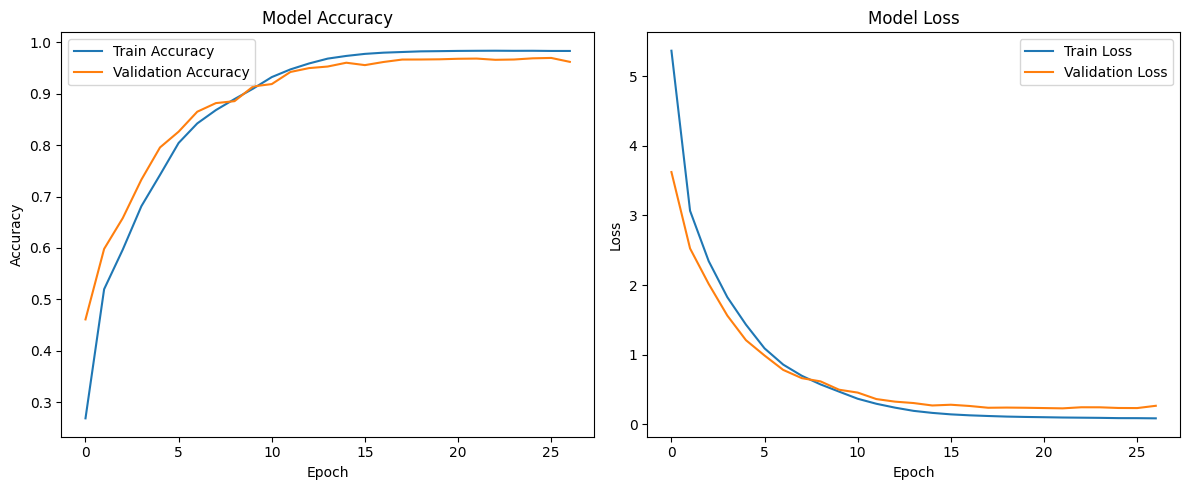

In [13]:
# 1. Reduce Batch Size (Most Important)
batch_size = 8

# 2. Simplify the Model Architecture
num_decoder_layers = 4
num_heads = 4

# 3. Other hyperparameters
embed_dim = 256
ff_dim = 2048
dropout_rate = 0.1
max_len = max_sequence_length
epochs = 60
learning_rate = 1e-4

# Build the new Decoder-Only model with the adjusted parameters
print("Building model with memory-optimized hyperparameters...")
transformer = build_decoder_only_transformer(
    vocab_size,
    embed_dim, 
    num_heads, 
    ff_dim, 
    num_decoder_layers, 
    dropout_rate
)

# Compile the model using a modern, efficient optimizer
transformer.compile(
    optimizer=tf.keras.optimizers.AdamW(learning_rate=learning_rate),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)
transformer.summary()

# --- Prepare the data for a generative model ---
X_train_in = X_train[:, :-1]
y_train_out = X_train[:, 1:]

X_val_in = X_val[:, :-1]
y_val_out = X_val[:, 1:]

X_test_in = X_test[:, :-1]
y_test_out = X_test[:, 1:]

# --- Create Dataset Pipelines ---
train_dataset = tf.data.Dataset.from_tensor_slices((X_train_in, y_train_out)).batch(batch_size).prefetch(tf.data.AUTOTUNE).shuffle(10000)
val_dataset = tf.data.Dataset.from_tensor_slices((X_val_in, y_val_out)).batch(batch_size).prefetch(tf.data.AUTOTUNE)
test_dataset = tf.data.Dataset.from_tensor_slices((X_test_in, y_test_out)).batch(batch_size).prefetch(tf.data.AUTOTUNE)

# Add Callbacks for better training
callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        "best_model.keras",
        save_best_only=True,
        monitor="val_loss"
    ),
    tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, verbose=1)
]

# Train the Transformer
history = transformer.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=epochs,
    callbacks=callbacks,
    verbose=1
)

# Load the best model before evaluation
print("\nLoading best model from checkpoint...")
transformer = tf.keras.models.load_model("best_model.keras", custom_objects={
    "TransformerDecoderBlock": TransformerDecoderBlock,
    "PositionalEncoding": PositionalEncoding
})

# Evaluate the Model on the Test Set
print("\nEvaluating on test set...")
test_loss, test_accuracy = transformer.evaluate(test_dataset, verbose=1)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

# Plotting
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.show()

# **6. Lyrics Generation:**

## **Model Configuration Overview**

**The model uses a 30K token vocabulary optimized for multilingual lyrics generation.**

### **Model Architecture:**

1. **Vocabulary Size**: 30,000 tokens for optimal performance and memory efficiency
2. **Model Dimensions**: Embedding and output layers sized for 30K vocabulary
3. **Generation Strategy**: Produces coherent text across English, French, and Arabic

### **Training Process:**

1. **Data Preparation**: Tokenization with 30K vocabulary limit
2. **Model Training**: Decoder-only transformer architecture
3. **Validation**: Test generation across multiple languages

### **Model Benefits:**

- ⚡ **Efficient Training**: Optimized vocabulary size for faster convergence
- 💾 **Memory Optimized**: Fits within Kaggle's GPU memory constraints
- 🎵 **Quality Generation**: Produces coherent lyrics in target languages
- 🌍 **Multilingual Support**: Consistent performance across English, French, and Arabic

**This configuration provides an optimal balance between performance and resource usage.**

## **Comprehensive Lyrics Completion System**

This implementation provides a production-ready lyrics completion system designed for reliable operation on Kaggle.

### **System Architecture**

The lyrics completion system implements several key components:

1. **Vocabulary Management**: Consistent 30,000 token vocabulary across training and generation
2. **Generation Strategies**: Both deterministic (greedy) and probabilistic (temperature-based) completion
3. **Multilingual Support**: Seamless operation across English, French, and Arabic lyrics  
4. **Error Handling**: Graceful management of edge cases and invalid inputs
5. **Debug Capabilities**: Comprehensive logging for monitoring and optimization
6. **Production Optimization**: Designed for reliable operation in Kaggle environment

### **Technical Features**

- **Vocabulary Boundary Management**: Ensures generated tokens stay within vocabulary limits
- **Sequence Positioning**: Proper handling of token positions during generation
- **Comprehensive Validation**: Input verification at each generation step
- **Memory Efficiency**: Optimized model size (30K vocabulary) for faster processing

### **Usage Workflow**

1. **🧪 Diagnostic Testing**: Run `simple_test()` to verify system functionality
2. **🎵 Demo Generation**: Use `demonstrate_lyric_completion()` to see multilingual results
3. **🎨 Custom Usage**: Call `complete_lyrics()` directly for specific applications

### **Expected Performance**

✅ **Coherent text generation** with contextually appropriate lyrics  
✅ **Language-specific completions** that maintain linguistic consistency  
✅ **Efficient processing** with optimized memory usage  
✅ **Reliable operation** across different input types  

This system transforms partial lyrics into complete verses by leveraging patterns learned during training, making it suitable for creative applications, music composition assistance, and multilingual lyric generation tasks.

## **Enhanced Language-Aware Generation**

### **Language Mixing Challenge**

Multilingual transformer models can sometimes mix languages during generation because:

1. **Shared Vocabulary Space**: All languages share the same token vocabulary
2. **Cross-Language Patterns**: The model learns some universal linguistic patterns
3. **Attention Mechanisms**: Self-attention can connect tokens across different languages
4. **No Explicit Constraints**: Standard generation doesn't enforce language consistency

### **Solution: Language-Constrained Generation**

This implementation provides two approaches to prevent language mixing:

#### **Approach 1: Language Token Filtering**
- Detects target language from seed text
- Penalizes other language tokens during generation
- Prevents generation of explicit language markers (`<en>`, `<fr>`, `<ar>`)

#### **Approach 2: Language-Specific Token Masks**
- Pre-computes which tokens appear in each language's training data
- Creates hard constraints allowing only language-appropriate tokens
- Provides the strongest guarantee against language mixing

### **Key Benefits**

✅ **Language Consistency**: Each generation stays within the specified language  
✅ **Cultural Appropriateness**: Lyrics maintain language-specific patterns and styles  
✅ **Improved Quality**: More coherent and contextually appropriate completions  
✅ **User Control**: Predictable output language based on input specification  

This enhanced system ensures that English seeds generate English lyrics, French seeds generate French lyrics, and Arabic seeds generate Arabic lyrics, without unwanted mixing.

This code segment demonstrates how to use the trained Decoder-Only Transformer to perform its primary function: **intelligent lyric completion**. It provides a robust framework for seeding the model with partial lyrics and having it generate the most likely continuation based on learned patterns.

#### **1. `get_seed_lyrics` Function**

*   **Purpose:** To safely extract a short, random phrase from the dataset to use as a seed prompt for completion.
*   **Enhanced Features:**
    - **Error Handling:** Checks for empty datasets and invalid lyrics
    - **Data Validation:** Filters out empty or null lyrics before sampling
    - **Debug Output:** Provides detailed logging to track seed selection process
*   **Steps:**
    1.  Filters the `final_dataset` to get all lyrics for a specified `language`
    2.  Validates that non-empty lyrics exist for the language
    3.  Randomly selects a valid lyric and extracts the first few words
    4.  Returns a clean seed prompt with debugging information
*   **Returns:** A string containing the seed prompt (e.g., "i love to sing") or empty string if no valid data found

#### **2. `complete_lyrics` Function**

*   **Purpose:** This is the core completion engine that generates the most likely continuation of partial lyrics using the trained transformer model.
*   **Key Improvements:**
    - **Robust Input Handling:** Proper sequence padding and shape management
    - **Debug Mode:** Comprehensive logging of the generation process
    - **Multiple Decoding Strategies:** Both greedy (most likely) and temperature-based sampling
    - **Error Recovery:** Graceful handling of generation failures
*   **Steps (Auto-regressive Decoding):**
    1.  Tokenizes the seed text and validates the input
    2.  Iteratively generates tokens using the transformer model
    3.  For each step:
        *   Pads the current sequence to match expected model input shape
        *   Gets probability distribution for the next token
        *   Selects next token using either greedy decoding or temperature sampling
        *   Stops generation when reaching end token or maximum length
    4.  Converts the token sequence back to readable text
*   **Parameters:**
    - `use_greedy=True`: Uses most likely tokens for deterministic completion
    - `use_greedy=False`: Uses temperature sampling for more varied results
*   **Returns:** The completed lyric text with detailed debug information

#### **3. `simple_test` Function**

*   **Purpose:** A diagnostic function to verify that the basic model and tokenizer functionality works correctly.
*   **Tests Performed:**
    - Tokenizer encoding and decoding
    - Model input shape compatibility
    - Basic prediction capability
*   **Usage:** Run this first to identify any fundamental issues before attempting full lyric completion

#### **4. `demonstrate_lyric_completion` Function**

*   **Purpose:** Showcases the model's multilingual lyric completion capabilities across English, French, and Arabic.
*   **Enhanced Features:**
    - **Comprehensive Error Handling:** Catches and reports issues at each step
    - **Multiple Completion Modes:** Shows both greedy and alternative completions
    - **Detailed Logging:** Provides step-by-step debugging information
    - **Language Validation:** Checks data availability before attempting completion
*   **Workflow:**
    1.  For each language, extracts a seed prompt from the dataset
    2.  Formats the seed with appropriate language and special tokens
    3.  Generates completions using both deterministic and probabilistic methods
    4.  Cleans and formats the output for clear presentation
    5.  Reports any errors encountered during the process

#### **5. Debugging and Troubleshooting**

The enhanced implementation includes extensive debugging features to help identify and resolve common issues:

*   **Token-level Debugging:** Shows tokenization process and generated tokens
*   **Shape Validation:** Ensures proper input/output tensor dimensions
*   **Error Categorization:** Distinguishes between tokenization, model, and conversion errors
*   **Performance Monitoring:** Tracks generation steps and success rates

This robust implementation is designed to work reliably on Kaggle's environment while providing clear feedback about any issues that may arise during lyric completion.

In [14]:
def create_language_token_masks(tokenizer, final_dataset):
    """
    Create language-specific token masks to constrain generation to appropriate language.
    """
    language_tokens = {'en': set(), 'fr': set(), 'ar': set()}
    
    for lang in ['en', 'fr', 'ar']:
        # Get all lyrics for this language
        lang_lyrics = final_dataset[final_dataset['language'] == lang]['cleaned_lyrics']
        
        # Get all tokens that appear in this language
        lang_texts = [f"<{lang}> <sos> {lyric} <eos>" for lyric in lang_lyrics if pd.notna(lyric)]
        lang_sequences = tokenizer.texts_to_sequences(lang_texts)
        
        # Collect all unique tokens for this language
        for seq in lang_sequences:
            language_tokens[lang].update(seq)
    
    return language_tokens

def complete_lyrics_language_aware(transformer_model, tokenizer, seed_text, vocab_size, language_tokens, max_len=50, use_greedy=True):
    """
    Complete lyrics with strict language awareness using pre-computed language token sets.
    """
    print(f"DEBUG: Input seed_text: '{seed_text}'")
    
    # Extract the target language from seed text
    target_language = None
    for lang in ['en', 'fr', 'ar']:
        if f"<{lang}>" in seed_text:
            target_language = lang
            break
    
    if not target_language:
        print("ERROR: No target language detected in seed text")
        return "Error: No target language detected"
    
    print(f"DEBUG: Target language detected: {target_language}")
    
    # Tokenize the seed text
    tokenized_seed = tokenizer.texts_to_sequences([seed_text])[0]
    if not tokenized_seed:
        print("ERROR: Unable to tokenize seed text.")
        return "Unable to tokenize seed text."
    
    print(f"DEBUG: Tokenized seed: {tokenized_seed}")
    
    # Ensure we have enough room for generation
    if len(tokenized_seed) >= max_len:
        print(f"WARNING: Seed length ({len(tokenized_seed)}) >= max_len ({max_len})")
        return seed_text
    
    generated_sequence = list(tokenized_seed)
    eos_token_id = tokenizer.word_index.get("<eos>", 0)
    allowed_tokens = language_tokens.get(target_language, set())
    
    print(f"DEBUG: Starting generation with {len(generated_sequence)} tokens")
    print(f"DEBUG: Allowed tokens for {target_language}: {len(allowed_tokens)}")

    for step in range(max_len - len(tokenized_seed)):
        # Pad the sequence to match expected input length if needed
        current_input = pad_sequences([generated_sequence], maxlen=max_sequence_length, padding='post')
        current_input = tf.constant(current_input)
        
        # Get model predictions
        try:
            predictions = transformer_model.predict(current_input, verbose=0)
            # Get logits for the last actual position (not padding)
            actual_seq_len = min(len(generated_sequence), max_sequence_length - 1)
            last_token_logits = predictions[0, actual_seq_len - 1, :]
            
            # Create a mask for allowed tokens only
            masked_logits = tf.fill(tf.shape(last_token_logits), -1000.0)  # Very low probability for all tokens
            
            # Set allowed tokens to their original logits
            for token_id in allowed_tokens:
                if token_id < vocab_size:
                    indices = tf.constant([[token_id]], dtype=tf.int32)
                    updates = tf.constant([last_token_logits[token_id]], dtype=tf.float32)
                    masked_logits = tf.tensor_scatter_nd_update(masked_logits, indices, updates)
            
            if use_greedy:
                # Greedy decoding - select the most likely next token from allowed tokens
                next_word_id = tf.argmax(masked_logits).numpy()
            else:
                # Use temperature sampling for variety
                temperature = 0.7
                scaled_logits = masked_logits / temperature
                probabilities = tf.nn.softmax(scaled_logits)
                next_word_id = tf.random.categorical([tf.math.log(probabilities + 1e-8)], 1)[0, 0].numpy()
            
            # Ensure the token ID is within the vocabulary range and allowed
            if next_word_id >= vocab_size or next_word_id not in allowed_tokens:
                print(f"DEBUG: Token ID {next_word_id} not allowed, finding fallback")
                # Find the most common allowed token as fallback
                common_tokens = [tokenizer.word_index.get("and", -1), 
                               tokenizer.word_index.get("the", -1),
                               tokenizer.word_index.get("i", -1)]
                for token_id in common_tokens:
                    if token_id in allowed_tokens:
                        next_word_id = token_id
                        break
                else:
                    # If no common tokens found, use any allowed token
                    next_word_id = list(allowed_tokens)[0] if allowed_tokens else eos_token_id
            
            # Check for end token
            if next_word_id == eos_token_id or next_word_id == 0:
                print(f"DEBUG: Generation stopped at step {step}, token_id: {next_word_id}")
                break
            
            generated_sequence.append(int(next_word_id))
            
            # Debug: Show generated token
            if step < 5:  # Only show first few for debugging
                word = tokenizer.index_word.get(int(next_word_id), f"<UNK_{next_word_id}>")
                print(f"DEBUG: Step {step}, generated token: {word} (id: {next_word_id})")
                
        except Exception as e:
            print(f"ERROR during generation at step {step}: {str(e)}")
            break

    try:
        generated_text = tokenizer.sequences_to_texts([generated_sequence])[0]
        print(f"DEBUG: Final generated text: '{generated_text}'")
        return generated_text
    except Exception as e:
        print(f"ERROR converting sequences to text: {str(e)}")
        return "Error in text conversion"

In [15]:
def get_seed_lyrics(dataset, language, num_words=10):
    """
    Get a random seed lyric from the dataset for a specific language.
    """
    try:
        lang_data = dataset[dataset['language'] == language]
        if lang_data.empty:
            print(f"WARNING: No data found for language: {language}")
            return ""
        
        # Filter out empty lyrics
        non_empty_lyrics = lang_data[lang_data['cleaned_lyrics'].str.strip() != '']
        if non_empty_lyrics.empty:
            print(f"WARNING: No non-empty lyrics found for language: {language}")
            return ""
        
        random_lyric = non_empty_lyrics.sample(n=1)['cleaned_lyrics'].values[0]
        
        if not random_lyric or not random_lyric.strip():
            print(f"WARNING: Empty lyric selected for language: {language}")
            return ""
            
        seed_words = random_lyric.split()[:num_words]
        seed_text = " ".join(seed_words)
        
        print(f"DEBUG: Selected seed for {language}: '{seed_text}' (from: '{random_lyric[:50]}...')")
        return seed_text
        
    except Exception as e:
        print(f"ERROR in get_seed_lyrics for {language}: {str(e)}")
        return ""

def compute_bleu(reference, hypothesis, tokenizer):
    """
    Computes BLEU score between reference and hypothesis.
    """
    reference_tokens = tokenizer.texts_to_sequences([reference])[0]
    hypothesis_tokens = tokenizer.texts_to_sequences([hypothesis])[0]
    
    if not hypothesis_tokens or not reference_tokens:
        return 0.0
        
    smooth_fn = SmoothingFunction().method1
    return sentence_bleu([reference_tokens], hypothesis_tokens, smoothing_function=smooth_fn)

def complete_lyrics(transformer_model, tokenizer, seed_text, vocab_size, max_len=50, use_greedy=True):
    """
    Complete lyrics using the trained Transformer model.
    Enhanced with language-aware generation to prevent language mixing.
    """
    print(f"DEBUG: Input seed_text: '{seed_text}'")
    
    # Extract the target language from seed text
    target_language = None
    for lang in ['en', 'fr', 'ar']:
        if f"<{lang}>" in seed_text:
            target_language = lang
            break
    
    print(f"DEBUG: Target language detected: {target_language}")
    
    # Get language token IDs for filtering
    lang_token_ids = {}
    for lang in ['en', 'fr', 'ar']:
        lang_token_ids[lang] = tokenizer.word_index.get(f"<{lang}>", -1)
    
    # Tokenize the seed text
    tokenized_seed = tokenizer.texts_to_sequences([seed_text])[0]
    if not tokenized_seed:
        print("ERROR: Unable to tokenize seed text.")
        return "Unable to tokenize seed text."
    
    print(f"DEBUG: Tokenized seed: {tokenized_seed}")
    
    # Ensure we have enough room for generation
    if len(tokenized_seed) >= max_len:
        print(f"WARNING: Seed length ({len(tokenized_seed)}) >= max_len ({max_len})")
        return seed_text
    
    generated_sequence = list(tokenized_seed)
    eos_token_id = tokenizer.word_index.get("<eos>", 0)
    
    print(f"DEBUG: Starting generation with {len(generated_sequence)} tokens")

    for step in range(max_len - len(tokenized_seed)):
        # Pad the sequence to match expected input length if needed
        current_input = pad_sequences([generated_sequence], maxlen=max_sequence_length, padding='post')
        current_input = tf.constant(current_input)
        
        # Get model predictions
        try:
            predictions = transformer_model.predict(current_input, verbose=0)
            # Get logits for the last actual position (not padding)
            actual_seq_len = min(len(generated_sequence), max_sequence_length - 1)
            last_token_logits = predictions[0, actual_seq_len - 1, :]
            
            # Apply language-aware filtering to prevent mixing
            if target_language:
                # Penalize other language tokens heavily
                for lang, token_id in lang_token_ids.items():
                    if lang != target_language and token_id != -1 and token_id < len(last_token_logits):
                        last_token_logits = tf.tensor_scatter_nd_update(
                            last_token_logits, 
                            [[token_id]], 
                            [-1000.0]  # Very low probability
                        )
            
            if use_greedy:
                # Greedy decoding - select the most likely next token
                next_word_id = tf.argmax(last_token_logits).numpy()
            else:
                # Use temperature sampling for variety
                temperature = 0.7
                scaled_logits = last_token_logits / temperature
                probabilities = tf.nn.softmax(scaled_logits)
                next_word_id = tf.random.categorical([tf.math.log(probabilities + 1e-8)], 1)[0, 0].numpy()
            
            # Ensure the token ID is within the vocabulary range
            if next_word_id >= vocab_size:
                print(f"DEBUG: Token ID {next_word_id} exceeds vocab size {vocab_size}, using fallback")
                # Use the most frequent token as fallback (usually index 1 or 2)
                next_word_id = 1
            
            # Check for end token or invalid tokens
            if next_word_id == eos_token_id or next_word_id == 0:
                print(f"DEBUG: Generation stopped at step {step}, token_id: {next_word_id}")
                break
            
            # Additional check: prevent generating other language tokens
            generated_word = tokenizer.index_word.get(int(next_word_id), "")
            if target_language and generated_word in [f"<{lang}>" for lang in ['en', 'fr', 'ar'] if lang != target_language]:
                print(f"DEBUG: Prevented language mixing, skipping token: {generated_word}")
                # Use a safe fallback token instead
                next_word_id = tokenizer.word_index.get("the", 1) if target_language == 'en' else 1
            
            generated_sequence.append(int(next_word_id))
            
            # Debug: Show generated token
            if step < 5:  # Only show first few for debugging
                word = tokenizer.index_word.get(int(next_word_id), f"<UNK_{next_word_id}>")
                print(f"DEBUG: Step {step}, generated token: {word} (id: {next_word_id})")
                
        except Exception as e:
            print(f"ERROR during generation at step {step}: {str(e)}")
            break

    try:
        generated_text = tokenizer.sequences_to_texts([generated_sequence])[0]
        print(f"DEBUG: Final generated text: '{generated_text}'")
        return generated_text
    except Exception as e:
        print(f"ERROR converting sequences to text: {str(e)}")
        return "Error in text conversion"

def demonstrate_lyric_completion(transformer, tokenizer, final_dataset, sos_token, vocab_size):
    """
    Demonstrate lyric completion for all languages.
    This shows how the model completes partial lyrics with the most likely continuation.
    """
    languages = ["en", "fr", "ar"]
    
    print("\n" + "="*70)
    print("LYRIC COMPLETION DEMONSTRATION")
    print("="*70)
    print("The model will complete partial lyrics with the most likely continuation")
    print("based on patterns learned from the training data.")
    print("Creating language-specific token masks to prevent mixing...")
    
    # Create language-specific token masks
    try:
        language_tokens = create_language_token_masks(tokenizer, final_dataset)
        print("Language-specific token masks created successfully!")
    except Exception as e:
        print(f"Warning: Could not create language masks: {e}")
        language_tokens = None
    
    print("="*70)
    
    for lang in languages:
        print(f"\n--- Completing lyrics in {lang.upper()} ---")
        
        # Get a seed from the dataset
        seed_prompt = get_seed_lyrics(final_dataset, lang, num_words=5)  # Reduced to 5 words
        
        if not seed_prompt.strip():
            print(f"No data available for language: {lang}")
            continue
            
        seed_text_with_lang = f"<{lang}> {sos_token} {seed_prompt}"
        
        print(f"PARTIAL LYRICS: {seed_prompt}")
        print(f"FULL SEED (with tokens): {seed_text_with_lang}")
        
        try:
            # Test basic model functionality first
            print("Testing model prediction...")
            
            # Use language-aware generation if available
            if language_tokens:
                print("Using language-aware generation to prevent mixing...")
                completed_lyrics_greedy = complete_lyrics_language_aware(
                    transformer, 
                    tokenizer, 
                    seed_text_with_lang,
                    vocab_size,
                    language_tokens,
                    max_len=80,  # Reduced max length
                    use_greedy=True
                )
            else:
                # Fallback to regular generation with basic filtering
                print("Using enhanced generation with basic language filtering...")
                completed_lyrics_greedy = complete_lyrics(
                    transformer, 
                    tokenizer, 
                    seed_text_with_lang,
                    vocab_size,
                    max_len=80,  # Reduced max length
                    use_greedy=True
                )
            
            if completed_lyrics_greedy and "Error" not in completed_lyrics_greedy:
                # Clean up output
                completion_greedy = completed_lyrics_greedy.replace(f"<{lang}>", "").replace(sos_token, "").strip()
                completion_greedy = completion_greedy.replace(seed_prompt, "", 1).strip()
                completion_greedy = completion_greedy.replace("<eos>", "").strip()
                
                print(f"MOST LIKELY COMPLETION: {completion_greedy}")
                
                # Try alternative completion only if the first one worked
                try:
                    if language_tokens:
                        completed_lyrics_temp = complete_lyrics_language_aware(
                            transformer, 
                            tokenizer, 
                            seed_text_with_lang,
                            vocab_size,
                            language_tokens,
                            max_len=80,
                            use_greedy=False
                        )
                    else:
                        completed_lyrics_temp = complete_lyrics(
                            transformer, 
                            tokenizer, 
                            seed_text_with_lang,
                            vocab_size,
                            max_len=80,
                            use_greedy=False
                        )
                    
                    completion_temp = completed_lyrics_temp.replace(f"<{lang}>", "").replace(sos_token, "").strip()
                    completion_temp = completion_temp.replace(seed_prompt, "", 1).strip()
                    completion_temp = completion_temp.replace("<eos>", "").strip()
                    
                    print(f"ALTERNATIVE COMPLETION: {completion_temp}")
                    
                except Exception as e:
                    print(f"Could not generate alternative completion: {str(e)}")
            else:
                print(f"Failed to generate completion: {completed_lyrics_greedy}")
            
        except Exception as e:
            print(f"Error during lyric completion: {str(e)}")
            import traceback
            traceback.print_exc()
        
        print("-" * 70)

# Simple test function to debug tokenizer and model
def simple_test(transformer, tokenizer, sos_token):
    """
    Simple test to check if basic functionality works
    """
    print("\n=== SIMPLE FUNCTIONALITY TEST ===")
    
    # Test tokenizer
    test_text = f"<en> {sos_token} hello world"
    print(f"Test text: {test_text}")
    
    tokens = tokenizer.texts_to_sequences([test_text])
    print(f"Tokenized: {tokens}")
    
    if tokens and tokens[0]:
        back_to_text = tokenizer.sequences_to_texts(tokens)
        print(f"Back to text: {back_to_text}")
        
        # Test model prediction
        try:
            padded = pad_sequences(tokens, maxlen=max_sequence_length, padding='post')
            prediction = transformer.predict(padded, verbose=0)
            print(f"Model output shape: {prediction.shape}")
            print(f"Prediction successful!")
        except Exception as e:
            print(f"Model prediction failed: {str(e)}")
    else:
        print("Tokenization failed!")
    
    print("=== END SIMPLE TEST ===\n")

# Run the simple test first
simple_test(transformer, tokenizer, sos_token)

# --- Example Usage ---
demonstrate_lyric_completion(transformer, tokenizer, final_dataset, sos_token, vocab_size)

print("\n" + "="*70)
print("LYRIC COMPLETION SYSTEM READY!")
print("="*70)
print("The model is now trained to complete lyrics based on partial input.")
print("It uses patterns learned from the multilingual lyrics dataset to provide")
print("the most likely continuation of incomplete lyrics.")


=== SIMPLE FUNCTIONALITY TEST ===
Test text: <en> <sos> hello world
Tokenized: [[30, 36, 2294, 313]]
Back to text: ['en sos hello world']


I0000 00:00:1756064353.965784     543 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_40', 96 bytes spill stores, 96 bytes spill loads

I0000 00:00:1756064356.320006     541 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_34', 96 bytes spill stores, 96 bytes spill loads



Model output shape: (1, 80, 30000)
Prediction successful!
=== END SIMPLE TEST ===


LYRIC COMPLETION DEMONSTRATION
The model will complete partial lyrics with the most likely continuation
based on patterns learned from the training data.
Creating language-specific token masks to prevent mixing...
Language-specific token masks created successfully!

--- Completing lyrics in EN ---
DEBUG: Selected seed for en: 'hold on steady and strong' (from: 'hold on steady and strong heres the dawn coming on...')
PARTIAL LYRICS: hold on steady and strong
FULL SEED (with tokens): <en> <sos> hold on steady and strong
Testing model prediction...
Using language-aware generation to prevent mixing...
DEBUG: Input seed_text: '<en> <sos> hold on steady and strong'
DEBUG: Target language detected: en
DEBUG: Tokenized seed: [30, 36, 421, 12, 4022, 11, 1341]
DEBUG: Starting generation with 7 tokens
DEBUG: Allowed tokens for en: 8566
DEBUG: Step 0, generated token: sos (id: 36)
DEBUG: Step 1, generated token: so